# Assignment 1

In [1]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2
#
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

import numpy as np

folder = "Your path to assignment folder" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [3]:
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from utils import seed_experiment, to_device, cross_entropy_loss, compute_accuracy
from config import get_config_parser
import json
from mlp import MLP
from resnet18 import ResNet18
from mlpmixer import MLPMixer
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os

In [4]:

import matplotlib
# matplotlib.use("GTK3Agg")
import numpy
import matplotlib.pyplot
import cv2 as cv

# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [9]:
import unittest
import test
suite = unittest.TestLoader().loadTestsFromModule(test)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (test.TestLinear) ... ok
test_linear_forward (test.TestLinear) ... ok
test_activation (test.TestMLP) ... ok
test_forward (test.TestMLP) ... ok
test_mlp (test.TestMLP) ... ok
test_mixer_block (test.TestMLPMixer) ... ok
test_mlpmixer (test.TestMLPMixer) ... ok
test_patch_emb (test.TestMLPMixer) ... ok
test_basic_block (test.TestResNet) ... ok
test_basic_block2 (test.TestResNet) ... ok
test_resnet (test.TestResNet) ... ok
test_ce_loss (test.TestUtils) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.461s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main_entry()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularizations).

In [5]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128
  # Model
  model: str = 'mlpmixer'  # [mlp, resnet18, mlpmixer]
  model_config: str = "model_configs/mlpmixer.json" # path to model config json file

  # Optimization
  optimizer: str = 'adam'  # [sgd, momentum, adam, adamw]
  epochs: int = 1
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-2

  # Experiment
  logdir: str = 'logdir_mlpmixer'
  seed: int = 42

  # Miscellaneous
  device: str = 'cuda'
  visualize : bool = False
  print_every: int = 80

In [6]:
# Main code entry. Train the model and save the logs
from main import train, evaluate

args = Arguments(model='mlpmixer',
                   model_config='model_configs/mlpmixer.json',
                   epochs=15*15, logdir="logdir_mlpmixer")

# def main_entry(args):
# Check for the device
if (args.device == "cuda") and not torch.cuda.is_available():
    warnings.warn(
        "CUDA is not available, make that your environment is "
        "running on GPU (e.g. in the Notebook Settings in Google Colab). "
        'Forcing device="cpu".'
    )
    args.device = "cpu"

if args.device == "cpu":
    warnings.warn(
        "You are about to run on CPU, and might run out of memory "
        "shortly. You can try setting batch_size=1 to reduce memory usage."
    )

# Seed the experiment, for repeatability
seed_experiment(args.seed)

test_transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                 ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                    ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# Load model
print(f'Build model {args.model.upper()}...')
if args.model_config is not None:
    print(f'Loading model config from {args.model_config}')
    with open(args.model_config) as f:
        model_config = json.load(f)
else:
    raise ValueError('Please provide a model config json')
print(f'########## {args.model.upper()} CONFIG ################')
for key, val in model_config.items():
    print(f'{key}:\t{val}')
print('############################################')
model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
model = model_cls(**model_config)
model.to(args.device)

# Optimizer
if args.optimizer == "adamw":
    optimizer = optim.AdamW(
        model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
elif args.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
elif args.optimizer == "sgd":
    optimizer = optim.SGD(
        model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
elif args.optimizer == "momentum":
    optimizer = optim.SGD(
        model.parameters(),
        lr=args.lr,
        momentum=args.momentum,
        weight_decay=args.weight_decay,
    )

print(
    f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
    f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
)

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
train_times, valid_times = [], []

# We define a set of data loaders that we can use for various purposes later.
train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
for epoch in range(args.epochs):
    tqdm.write(f"====== Epoch {epoch} ======>")
    loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer,args)
    train_losses.append(loss)
    train_accs.append(acc)
    train_times.append(wall_time)

    loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
    valid_losses.append(loss)
    valid_accs.append(acc)
    valid_times.append(wall_time)

test_loss, test_acc, test_time = evaluate(
    epoch, model, test_dataloader, args, mode="test"
)
print(f"===== Best validation Accuracy: {max(valid_accs):.3f} =====>")

# Save log if logdir provided
if args.logdir is not None:
    print(f'Writing training logs to {args.logdir}...')
    os.makedirs(args.logdir, exist_ok=True)
    with open(os.path.join(args.logdir, 'results.json'), 'w') as f:
        f.write(json.dumps(
            {
                "train_losses": train_losses,
                "valid_losses": valid_losses,
                "train_accs": train_accs,
                "valid_accs": valid_accs,
                "test_loss": test_loss,
                "test_acc": test_acc
            },
            indent=4,
        ))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	512
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 8570634 total parameters, of which 8570634 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.55152
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.76126
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61908
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.49597
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.48758
== [TRAIN] Epoch: 0, Accuracy: 0.400 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.45697
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.498 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.36693
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.31836
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.41626
[TRAIN] Ep

In [75]:
for epoch in range(15*15):
    tqdm.write(f"====== Epoch {epoch} ======>")
    loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer,args)
    train_losses.append(loss)
    train_accs.append(acc)
    train_times.append(wall_time)

    loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
    valid_losses.append(loss)
    valid_accs.append(acc)
    valid_times.append(wall_time)


====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 0.03674
[TRAIN] Epoch: 0, Iter: 80, Loss: 0.01746
[TRAIN] Epoch: 0, Iter: 160, Loss: 0.07900
[TRAIN] Epoch: 0, Iter: 240, Loss: 0.06060
[TRAIN] Epoch: 0, Iter: 320, Loss: 0.03296
== [TRAIN] Epoch: 0, Accuracy: 0.977 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 0.25430
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.961 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.03147
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.05233
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.09831
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.07717
[TRAIN] Epoch: 1, Iter: 320, Loss: 0.02239
== [TRAIN] Epoch: 1, Accuracy: 0.979 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 0.32531
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.965 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 0.02560
[TRAIN] Epoch: 2, Iter: 80, Loss: 0.02079
[TRAIN] Epoch: 2, Iter: 160, Loss: 0.03675
[TRAIN] Epoch: 2, Iter: 240, Loss: 0.05171
[TRAIN] Epoch: 2, Iter: 320, Loss: 0.02716
== [TRAIN] Epoch: 2, Accuracy: 0.

KeyboardInterrupt: 

In [74]:
loss, acc, wall_time = evaluate(0, model, valid_dataloader, args)

[VAL] Epoch: 0, Iter: 0, Loss: 0.27741
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.964 ===>


In [61]:
model.blocks[0]

MixerBlock(
  (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  (mlp_tokens): Mlp(
    (fc1): Linear(in_features=64, out_features=256, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=256, out_features=64, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  (mlp_channels): Mlp(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
)

In [62]:
model_config

{'num_classes': 10,
 'img_size': 32,
 'patch_size': 4,
 'embed_dim': 512,
 'num_blocks': 4,
 'drop_rate': 0.0,
 'activation': 'gelu'}

In [8]:
F = int(numpy.sqrt(model_config["img_size"]**2/model_config["patch_size"]**2))
D_S = int(model_config["embed_dim"]*0.5)
print(F, D_S)

8 256


In [9]:
cv1w = numpy.array(model.blocks[0].mlp_tokens.fc1.weight.cpu().detach().numpy())
w_min, w_max = numpy.max(cv1w), numpy.min(cv1w)
cv1w_norm = (cv1w - w_min)/(w_max - w_min)
print(cv1w_norm.shape)

(256, 64)


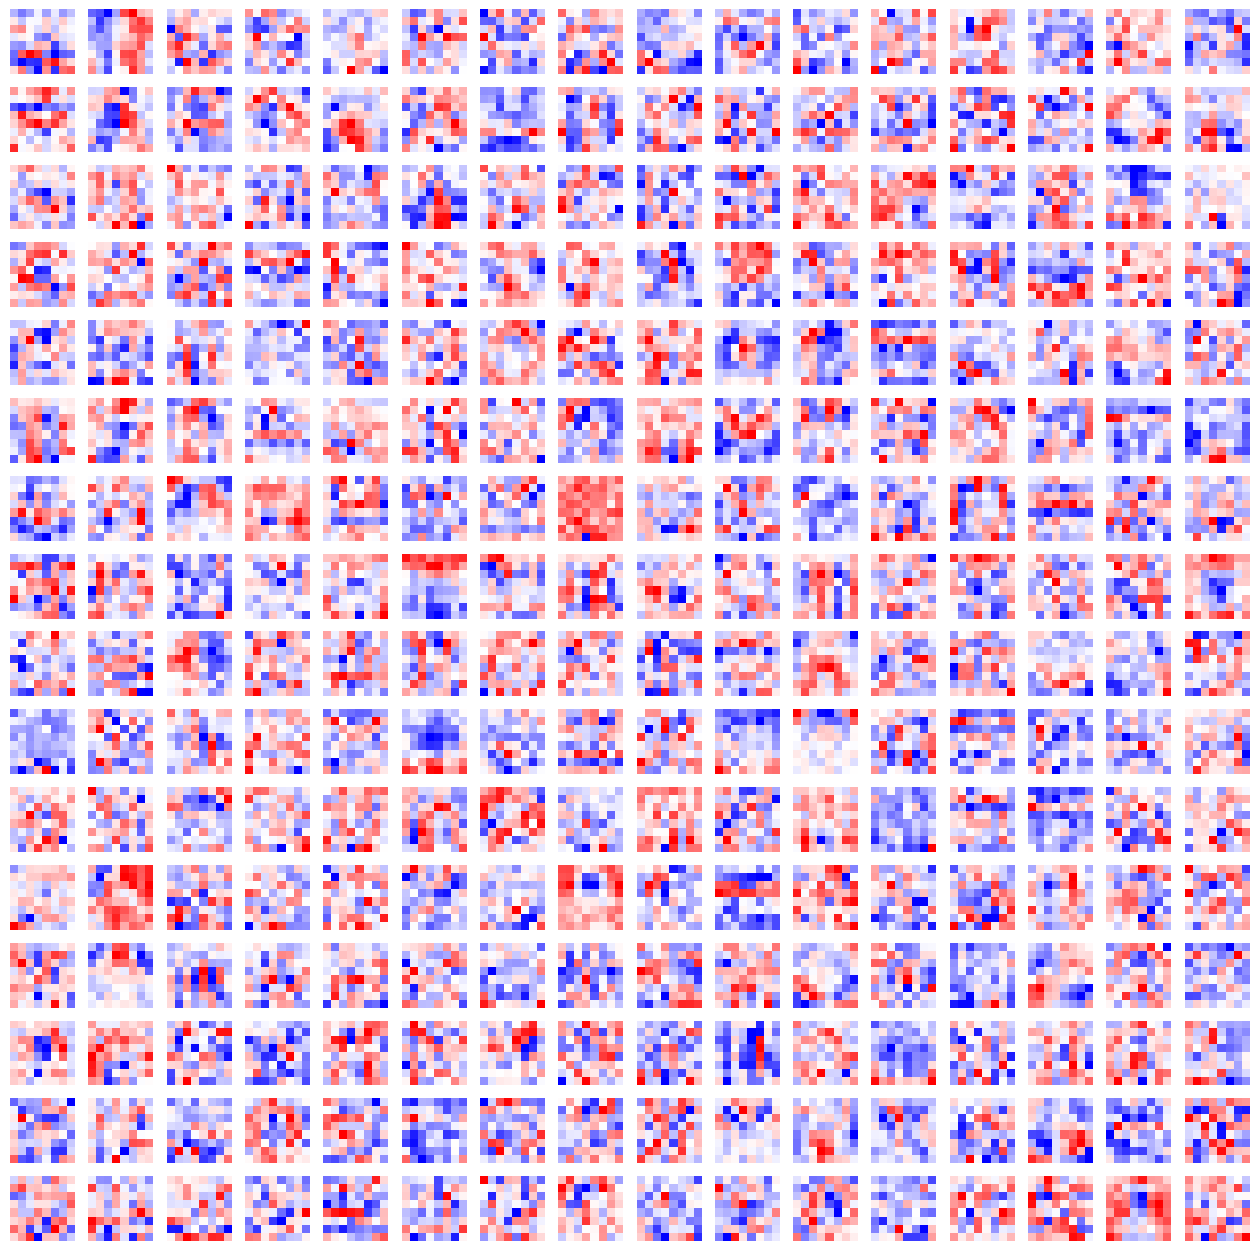

In [10]:
matplotlib.pyplot.figure(figsize=(16,16))
for i, filter in enumerate(cv1w_norm):
    matplotlib.pyplot.subplot(16, 16, i+1)
    matplotlib.pyplot.imshow(filter.reshape(F, F), cmap='bwr')
    matplotlib.pyplot.axis('off')
matplotlib.pyplot.savefig("mlpmixer_filter.pdf")
matplotlib.pyplot.show()

In [186]:
# matplotlib.pyplot.figure(figsize=(16, 8))
# for i, filter in enumerate(cv1w):
#     matplotlib.pyplot.subplot(8, 16, i+1)
#     matplotlib.pyplot.imshow(filter.reshape(F, F), cmap='bwr')
#     matplotlib.pyplot.axis('off')
# # matplotlib.pyplot.savefig("mlpmixer_filter.pdf")
# matplotlib.pyplot.show()

In [64]:
# matplotlib.pyplot.figure(figsize=(8, 64))
# k = 0
# for i, filter in enumerate(cv1w_norm):
#     for j in range(8):
#         k += 1
#         matplotlib.pyplot.subplot(64, 8, k)
#         matplotlib.pyplot.imshow(filter[j, :, :], cmap='gray')
#         matplotlib.pyplot.axis('off')
# matplotlib.pyplot.savefig("mlpmixer_wall8.pdf")
# matplotlib.pyplot.show()

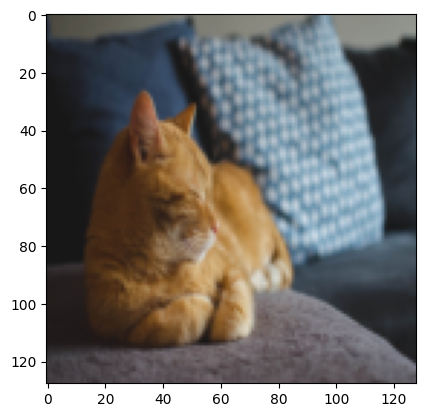

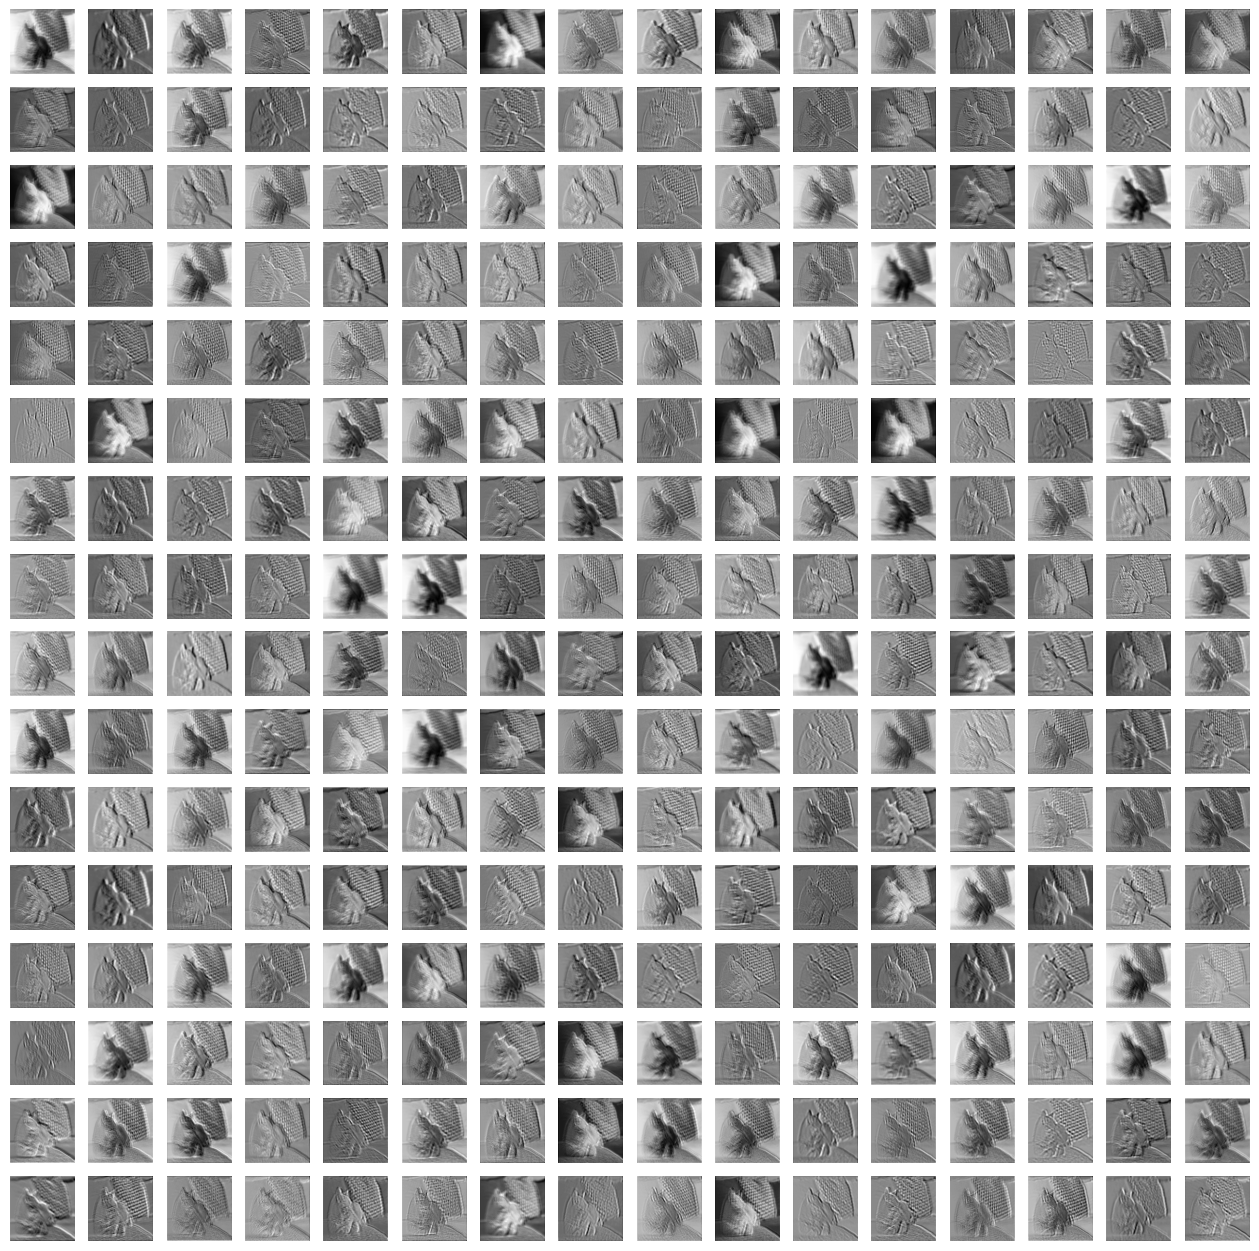

In [73]:
# read and visualize an image
img = cv.imread(f"cat.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# define the transforms
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((128, 128)), transforms.ToTensor(),])

img = np.array(img)
img = transform(img)
img = img.unsqueeze(0)

matplotlib.pyplot.imshow(numpy.transpose(numpy.transpose(img[0], axes=(2,0,1)),  axes=(2,0,1)))
matplotlib.pyplot.savefig("cat.pdf")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize=(16,16))
for i, filter in enumerate(cv1w):
    f = torch.tensor(filter.reshape(F, F)).expand(1, 1, F, F)
    matplotlib.pyplot.subplot(16, 16, i + 1)
    conv_img = torch.nn.functional.conv2d(img[:, 0, None, :, :], f, stride=1, padding=1)
    matplotlib.pyplot.imshow(conv_img[0][0], cmap='gray')
    # conv_img1 = torch.nn.functional.conv2d(img[:, 0, None, :, :], f, stride=1, padding=1)[0]
    # conv_img2 = torch.nn.functional.conv2d(img[:, 1, None, :, :], f, stride=1, padding=1)[0]
    # conv_img3 = torch.nn.functional.conv2d(img[:, 2, None, :, :], f, stride=1, padding=1)[0]
    # matplotlib.pyplot.imshow(numpy.transpose(numpy.transpose(numpy.concatenate([conv_img1, conv_img2, conv_img3]), axes=(2,0,1)),  axes=(2,0,1)), cmap='gray')

    matplotlib.pyplot.axis("off")
matplotlib.pyplot.savefig("cat_conv.pdf")
matplotlib.pyplot.show()


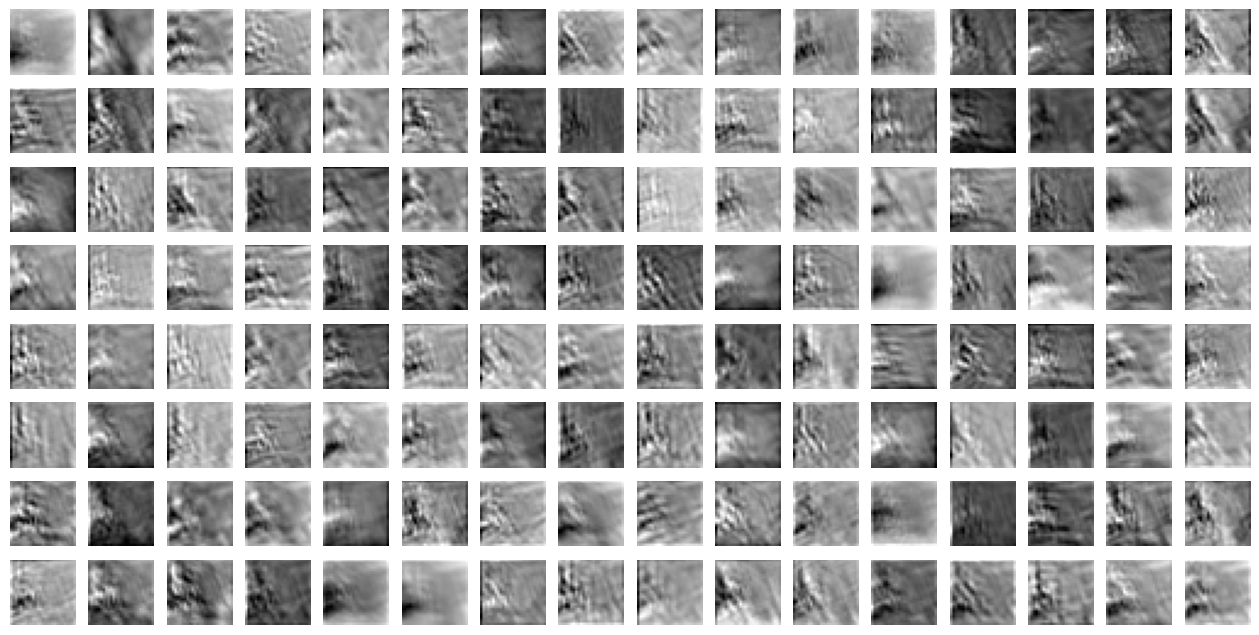

In [56]:
img = transforms.ToTensor()(test_dataloader.dataset.data[7])

matplotlib.pyplot.figure(figsize=(16, 8))
for i in range(8*16):
    f = torch.tensor(cv1w[i].reshape(F, F)).expand(1, 1, F, F)
    matplotlib.pyplot.subplot(8, 16, i + 1)
    # conv_img1 = torch.nn.functional.conv2d(img[0, None, :, :], f, stride=1, padding=1)
    # conv_img2 = torch.nn.functional.conv2d(img[1, None, :, :], f, stride=1, padding=1)
    # conv_img3 = torch.nn.functional.conv2d(img[2, None, :, :], f, stride=1, padding=1)
    # matplotlib.pyplot.imshow(numpy.transpose(numpy.transpose(numpy.concatenate([conv_img1, conv_img2, conv_img3]), axes=(2,0,1)),  axes=(2,0,1)), cmap='gray')

    # conv_img1 = torch.nn.functional.conv2d(img[0, None, :, :], f, stride=1, padding=1)
    # conv_img2 = torch.nn.functional.conv2d(img[1, None, :, :], f, stride=1, padding=1)
    conv_img3 = torch.nn.functional.conv2d(img[1, None, :, :], f, stride=1, padding=1)
    matplotlib.pyplot.imshow(conv_img3[0], cmap='gray')
    matplotlib.pyplot.axis("off")
matplotlib.pyplot.savefig("frog_conv.pdf")
matplotlib.pyplot.show()


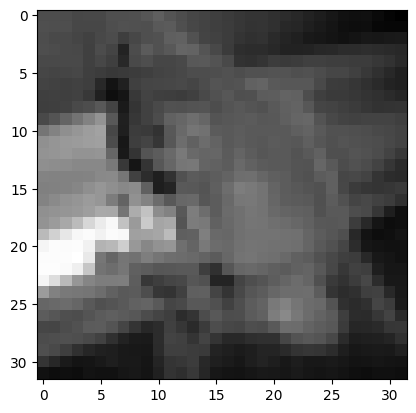

In [55]:
matplotlib.pyplot.imshow(test_dataloader.dataset.data[7][:,:, 1], cmap='gray')

In [108]:
t = transforms.Resize((64, 64))
t(test_dataloader.dataset.data[7])

TypeError: Unexpected type <class 'numpy.ndarray'>

In [19]:
# Main code entry. Train the model and save the logs
from main import train, evaluate

for P in [2, 4, 8, 16, 32]:
    args = Arguments(model='mlpmixer',
                       model_config='model_configs/mlpmixer_' + str(P) + '.json',
                       epochs=1)

    # def main_entry(args):
    # Check for the device
    if (args.device == "cuda") and not torch.cuda.is_available():
        warnings.warn(
            "CUDA is not available, make that your environment is "
            "running on GPU (e.g. in the Notebook Settings in Google Colab). "
            'Forcing device="cpu".'
        )
        args.device = "cpu"

    if args.device == "cpu":
        warnings.warn(
            "You are about to run on CPU, and might run out of memory "
            "shortly. You can try setting batch_size=1 to reduce memory usage."
        )

    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform)

    # Load model
    # print(f'Build model {args.model.upper()}...')
    if args.model_config is not None:
        print(f'Loading model config from {args.model_config}')
        with open(args.model_config) as f:
            model_config = json.load(f)
    else:
        raise ValueError('Please provide a model config json')
    model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
    model = model_cls(**model_config)
    model.to(args.device)

    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )

    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )
    print(model.blocks[0])
    # print(model.blocks[0])

    print()


Loading model config from model_configs/mlpmixer_2.json
Initialized MLPMIXER model with 2376458 total parameters, of which 2376458 are learnable.
MixerBlock(
  (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (mlp_tokens): Mlp(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (mlp_channels): Mlp(
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
)

Loading model config from model_configs/mlpmixer_4.json
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 are learnable.
MixerBloc